**Student Name:** Ayanda Sibusiso Dlamini

**Student ID :** 411221337

**Department :** CSIE

**Grade:** Juniour

# **ASSIGNMENT 1**

CNN model using the PyTorch framework with the Cat and Dog


*The process of building a Convolutional Neural Network always involves four major steps.*

**Step - 1 : Convolution**

**Step - 2 : Pooling**

**Step - 3 : Flattening**

**Step - 4 : Full connection**


In [4]:
# Check PyTorch & GPU
import torch, torchvision
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
!nvidia-smi -L || true   # shows GPU if available (safe if not)


torch: 2.8.0+cu126 cuda: True
GPU 0: Tesla T4 (UUID: GPU-515288ad-340f-99fc-2fb1-edbfa80a3a65)


🧩 Step 1: Mount Google Drive in Colab



In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Locating My Dataset

In [6]:
!ls /content/drive/MyDrive/GenAI/cats_dogs


test_set.zip


Unzip the Dataset

In [7]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/GenAI/cats_dogs/test_set.zip'
extract_path = '/content/dataset'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files to:", extract_path)


Extracted files to: /content/dataset


In [6]:
!ls /content/dataset


test_set


Split test_set into train and val

In [8]:
import os
import glob
import shutil
import random

random.seed(42)

src_dir = '/content/dataset/test_set'
output_root = '/content/dataset'
val_split = 0.2  # 20% for validation

for cls in ['cats', 'dogs']:
    imgs = glob.glob(os.path.join(src_dir, cls, '*.*'))
    random.shuffle(imgs)
    split_idx = int(len(imgs) * (1 - val_split))

    # train folder
    train_folder = os.path.join(output_root, 'train', cls)
    os.makedirs(train_folder, exist_ok=True)
    for img_path in imgs[:split_idx]:
        shutil.copy(img_path, train_folder)

    # val folder
    val_folder = os.path.join(output_root, 'val', cls)
    os.makedirs(val_folder, exist_ok=True)
    for img_path in imgs[split_idx:]:
        shutil.copy(img_path, val_folder)

print("Dataset split complete!")
print("Train folder:", os.listdir(os.path.join(output_root, 'train')))
print("Val folder:", os.listdir(os.path.join(output_root, 'val')))


Dataset split complete!
Train folder: ['cats', 'dogs']
Val folder: ['cats', 'dogs']


Load the datasets with DataLoaders

In [9]:
# Import datasets and transforms from torchvision for handling image data and augmentations
from torchvision import datasets, transforms
# Import DataLoader to efficiently load batches of data during training
from torch.utils.data import DataLoader

# Define the target size for images (width and height)
img_size = 128
# Define the batch size for training and validation
batch_size = 32

# Define transformations for training data
train_tfms = transforms.Compose([
    # Resize all images to img_size x img_size
    transforms.Resize((img_size,img_size)),
    # Apply random horizontal flip for data augmentation
    transforms.RandomHorizontalFlip(),
    # Convert images to PyTorch tensors
    transforms.ToTensor()
])

# Define transformations for validation data
val_tfms = transforms.Compose([
    # Resize images to img_size x img_size
    transforms.Resize((img_size,img_size)),
    # Convert images to PyTorch tensors
    transforms.ToTensor()
])

# Load training dataset from folder and apply training transformations
train_dataset = datasets.ImageFolder('/content/dataset/train', transform=train_tfms)
# Load validation dataset from folder and apply validation transformations
val_dataset = datasets.ImageFolder('/content/dataset/val', transform=val_tfms)

# Create DataLoader for training dataset with batch processing and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset with batch processing, no shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print the class labels detected in the dataset
print("Classes:", train_dataset.classes)
# Print the total number of training samples
print("Number of training samples:", len(train_dataset))
# Print the total number of validation samples
print("Number of validation samples:", len(val_dataset))


Classes: ['cats', 'dogs']
Number of training samples: 1617
Number of validation samples: 406


Definition the CNN model and training

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple Convolutional Neural Network for binary classification (cats vs dogs)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Max pooling layer with 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Fully connected layer: 64*32*32 input features, 128 output features
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # Output layer: 128 input features, 2 output classes (cats and dogs)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Apply first conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps into a vector for the fully connected layers
        x = x.view(-1, 64 * 32 * 32)
        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply output layer (no activation here because CrossEntropyLoss includes softmax)
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = SimpleCNN().to(device)

# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs for training
epochs = 5

from tqdm import tqdm  # import tqdm for progress bar

# Training loop with progress bar
for epoch in range(epochs):
    running_loss = 0.0
    # Wrap train_loader with tqdm to show progress
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print average loss at the end of the epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model to a file
torch.save(model.state_dict(), '/content/cats_dogs_cnn.pth')
print("Model saved successfully!")


Epoch 1/5: 100%|██████████| 51/51 [00:05<00:00,  8.64it/s]


Epoch [1/5], Loss: 0.7781


Epoch 2/5: 100%|██████████| 51/51 [00:05<00:00,  8.78it/s]


Epoch [2/5], Loss: 0.6674


Epoch 3/5: 100%|██████████| 51/51 [00:04<00:00, 10.58it/s]


Epoch [3/5], Loss: 0.6511


Epoch 4/5: 100%|██████████| 51/51 [00:05<00:00,  9.62it/s]


Epoch [4/5], Loss: 0.6201


Epoch 5/5: 100%|██████████| 51/51 [00:05<00:00,  9.67it/s]

Epoch [5/5], Loss: 0.5758
Model saved successfully!


Set up a validation loop and also plot graphs for training and validation performance (loss and accuracy).

Epoch 1/30: 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]


Epoch [1/30] -> Train Loss: 0.7249, Train Acc: 53.31%, Val Loss: 0.6772, Val Acc: 56.40%


Epoch 2/30: 100%|██████████| 51/51 [00:04<00:00, 10.61it/s]


Epoch [2/30] -> Train Loss: 0.6703, Train Acc: 58.57%, Val Loss: 0.6652, Val Acc: 57.39%


Epoch 3/30: 100%|██████████| 51/51 [00:05<00:00,  8.82it/s]


Epoch [3/30] -> Train Loss: 0.6566, Train Acc: 60.42%, Val Loss: 0.6664, Val Acc: 56.16%


Epoch 4/30: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]


Epoch [4/30] -> Train Loss: 0.6421, Train Acc: 62.28%, Val Loss: 0.6600, Val Acc: 60.34%


Epoch 5/30: 100%|██████████| 51/51 [00:05<00:00,  9.23it/s]


Epoch [5/30] -> Train Loss: 0.6074, Train Acc: 67.04%, Val Loss: 0.6507, Val Acc: 63.55%


Epoch 6/30: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]


Epoch [6/30] -> Train Loss: 0.5722, Train Acc: 69.02%, Val Loss: 0.7342, Val Acc: 57.88%


Epoch 7/30: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s]


Epoch [7/30] -> Train Loss: 0.5338, Train Acc: 72.85%, Val Loss: 0.6555, Val Acc: 60.59%


Epoch 8/30: 100%|██████████| 51/51 [00:04<00:00, 10.48it/s]


Epoch [8/30] -> Train Loss: 0.5350, Train Acc: 73.65%, Val Loss: 0.6777, Val Acc: 64.29%


Epoch 9/30: 100%|██████████| 51/51 [00:05<00:00, 10.19it/s]


Epoch [9/30] -> Train Loss: 0.4839, Train Acc: 76.07%, Val Loss: 0.7098, Val Acc: 67.24%


Epoch 10/30: 100%|██████████| 51/51 [00:05<00:00,  9.92it/s]


Epoch [10/30] -> Train Loss: 0.4234, Train Acc: 80.21%, Val Loss: 0.7301, Val Acc: 64.29%


Epoch 11/30: 100%|██████████| 51/51 [00:04<00:00, 10.73it/s]


Epoch [11/30] -> Train Loss: 0.4077, Train Acc: 81.63%, Val Loss: 0.7155, Val Acc: 64.04%


Epoch 12/30: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s]


Epoch [12/30] -> Train Loss: 0.3716, Train Acc: 83.06%, Val Loss: 0.6808, Val Acc: 65.27%


Epoch 13/30: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]


Epoch [13/30] -> Train Loss: 0.3281, Train Acc: 86.52%, Val Loss: 0.8463, Val Acc: 66.50%


Epoch 14/30: 100%|██████████| 51/51 [00:05<00:00,  9.15it/s]


Epoch [14/30] -> Train Loss: 0.2982, Train Acc: 86.89%, Val Loss: 0.8685, Val Acc: 64.29%


Epoch 15/30: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]


Epoch [15/30] -> Train Loss: 0.2494, Train Acc: 89.42%, Val Loss: 0.8880, Val Acc: 65.27%


Epoch 16/30: 100%|██████████| 51/51 [00:05<00:00,  8.83it/s]


Epoch [16/30] -> Train Loss: 0.2134, Train Acc: 91.28%, Val Loss: 0.8206, Val Acc: 66.01%


Epoch 17/30: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]


Epoch [17/30] -> Train Loss: 0.1538, Train Acc: 94.12%, Val Loss: 0.9572, Val Acc: 65.27%


Epoch 18/30: 100%|██████████| 51/51 [00:05<00:00,  8.85it/s]


Epoch [18/30] -> Train Loss: 0.1492, Train Acc: 94.99%, Val Loss: 1.0169, Val Acc: 67.73%


Epoch 19/30: 100%|██████████| 51/51 [00:04<00:00, 10.58it/s]


Epoch [19/30] -> Train Loss: 0.1116, Train Acc: 96.10%, Val Loss: 1.1280, Val Acc: 67.49%


Epoch 20/30: 100%|██████████| 51/51 [00:05<00:00,  8.83it/s]


Epoch [20/30] -> Train Loss: 0.1112, Train Acc: 96.29%, Val Loss: 1.1721, Val Acc: 66.75%


Epoch 21/30: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]


Epoch [21/30] -> Train Loss: 0.0925, Train Acc: 96.41%, Val Loss: 1.1741, Val Acc: 65.52%


Epoch 22/30: 100%|██████████| 51/51 [00:05<00:00,  8.69it/s]


Epoch [22/30] -> Train Loss: 0.0654, Train Acc: 97.77%, Val Loss: 1.3224, Val Acc: 67.98%


Epoch 23/30: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]


Epoch [23/30] -> Train Loss: 0.0462, Train Acc: 98.70%, Val Loss: 1.3780, Val Acc: 66.01%


Epoch 24/30: 100%|██████████| 51/51 [00:06<00:00,  7.46it/s]


Epoch [24/30] -> Train Loss: 0.0390, Train Acc: 99.07%, Val Loss: 1.3932, Val Acc: 65.52%


Epoch 25/30: 100%|██████████| 51/51 [00:04<00:00, 10.49it/s]


Epoch [25/30] -> Train Loss: 0.0363, Train Acc: 99.13%, Val Loss: 1.5512, Val Acc: 65.27%


Epoch 26/30: 100%|██████████| 51/51 [00:05<00:00,  9.21it/s]


Epoch [26/30] -> Train Loss: 0.0209, Train Acc: 99.57%, Val Loss: 1.7070, Val Acc: 68.97%


Epoch 27/30: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]


Epoch [27/30] -> Train Loss: 0.0287, Train Acc: 99.44%, Val Loss: 1.4876, Val Acc: 67.73%


Epoch 28/30: 100%|██████████| 51/51 [00:05<00:00,  9.80it/s]


Epoch [28/30] -> Train Loss: 0.0332, Train Acc: 98.89%, Val Loss: 1.7637, Val Acc: 68.72%


Epoch 29/30: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]


Epoch [29/30] -> Train Loss: 0.0196, Train Acc: 99.63%, Val Loss: 1.6636, Val Acc: 67.00%


Epoch 30/30: 100%|██████████| 51/51 [00:05<00:00, 10.01it/s]


Epoch [30/30] -> Train Loss: 0.0166, Train Acc: 99.63%, Val Loss: 1.8194, Val Acc: 68.23%
Model saved successfully!


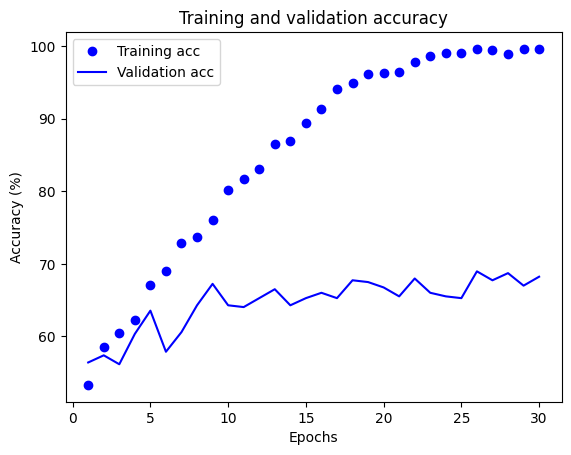

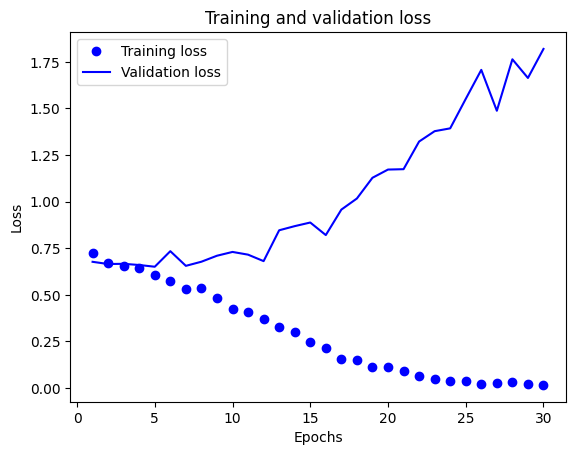

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple Convolutional Neural Network for binary classification (cats vs dogs)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Max pooling layer with 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Fully connected layer: 64*32*32 input features, 128 output features
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # Output layer: 128 input features, 2 output classes (cats and dogs)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Apply first conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps into a vector for the fully connected layers
        x = x.view(-1, 64 * 32 * 32)
        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply output layer (no activation here because CrossEntropyLoss includes softmax)
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = SimpleCNN().to(device)

# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs to match the original notebook for better accuracy
epochs = 30

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Validation function
def validate(model, val_loader, criterion):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop with validation at each epoch
from tqdm import tqdm  # import tqdm for progress bar

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for training
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Run validation
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] -> "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'cats_and_dogs_small_1.pth')
print("Model saved successfully!")

# ------------------------------
# Keras-style plotting
# ------------------------------
epochs_range = range(1, epochs+1)

# Accuracy graph
plt.plot(epochs_range, train_accuracies, 'bo', label='Training acc')  # blue dots
plt.plot(epochs_range, val_accuracies, 'b', label='Validation acc')  # blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.figure()

# Loss graph
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')  # blue dots
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')  # blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now i need to improve the accuracy by incorporating Batch Normalization and Dropout.